In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB
import pickle
import logging
import folium

## Extract POIs within Bishan

Extract all the Point of Interests that are within the Bishan area.

In [7]:
# Load the CSV file
poi_data = pd.read_csv("data/CombinedPOI.csv")


# Define a function to check if a point is within the Woodlands area
def is_within_bishan(row):
    bishan_latitude_range = (1.3425, 1.3648)
    bishan_longitude_range = (103.8322, 103.8584)
    
    return (bishan_longitude_range[0] <= row["longitude"] <= bishan_longitude_range[1]) and \
           (bishan_latitude_range[0] <= row["latitude"] <= bishan_latitude_range[1])

# Filter the POI data to extract the entries within the Woodlands area
bishan_pois_df = poi_data[poi_data.apply(is_within_bishan, axis=1)]
#reset index
bishan_pois_df = bishan_pois_df.reset_index(drop=True)

# Print the extracted POIs in the Woodlands area
print("POIs in the Bishan area:")
print(bishan_pois_df)

#bishan_pois_df.to_csv("bishan_pois.csv") 

POIs in the Bishan area:
                  name  latitude   longitude           type
0     101 BISHAN ST 12  1.344859  103.848401   HDB Property
1     102 BISHAN ST 12  1.345143  103.847991   HDB Property
2     103 BISHAN ST 12  1.345512  103.848314   HDB Property
3     104 BISHAN ST 12  1.345675  103.848033   HDB Property
4     105 BISHAN ST 12  1.345895  103.847365   HDB Property
..                 ...       ...         ...            ...
321  514B BISHAN ST 13  1.350784  103.850396   HDB Property
322  514C BISHAN ST 13  1.350643  103.850394   HDB Property
323         Junction 8  1.350172  103.848554  Shopping Mall
324          Thomson V  1.353195  103.835565  Shopping Mall
325         Junction 8  1.350172  103.848554  Shopping Mall

[326 rows x 4 columns]


## Extract carparks within Bishan

Extract all the carparks that are within the Bishan area

In [8]:
# Load the CSV file
cp_data = pd.read_csv("data/CombinedCarpark.csv")

# Define a function to check if a point is within the Woodlands area
def is_within_bishan(row):
    bishan_latitude_range = (1.3425, 1.3648)
    bishan_longitude_range = (103.8322, 103.8584)
    
    return (bishan_longitude_range[0] <= row["longitude"] <= bishan_longitude_range[1]) and \
           (bishan_latitude_range[0] <= row["latitude"] <= bishan_latitude_range[1])

# Filter the POI data to extract the entries within the Woodlands area
bishan_cp_df = cp_data[cp_data.apply(is_within_bishan, axis=1)]
#reset index
bishan_cp_df = bishan_cp_df.reset_index(drop=True)

# Print the extracted POIs in the Woodlands area
print("Carparks in the Bishan area:")
print(bishan_cp_df)
len(bishan_cp_df)

Carparks in the Bishan area:
          name  latitude   longitude                   type
0         AM20  1.364698  103.846089            HDB Carpark
1         AM22  1.364588  103.847653            HDB Carpark
2         AM96  1.364074  103.850940            HDB Carpark
3         BE13  1.344886  103.851528            HDB Carpark
4         BE14  1.347059  103.855432            HDB Carpark
5         BE15  1.345163  103.854838            HDB Carpark
6         BE20  1.348892  103.848665            HDB Carpark
7         BE23  1.350096  103.849763            HDB Carpark
8         BE25  1.355154  103.848309            HDB Carpark
9         BE27  1.356656  103.848631            HDB Carpark
10        BE3R  1.363186  103.835476            HDB Carpark
11        BE30  1.357464  103.846445            HDB Carpark
12        BE32  1.359171  103.846672            HDB Carpark
13        BE34  1.360961  103.843622            HDB Carpark
14        BE37  1.358008  103.844421            HDB Carpark
15        B

25

In [9]:
# Create a map centered at Woodlands, Singapore
bishan_map = folium.Map(location=[1.3508, 103.8395], zoom_start=13)

# Add markers for all the carparks in the Woodlands area (blue markers)
for _, row in bishan_cp_df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=row["name"], icon=folium.Icon(color='blue')).add_to(bishan_map)

# Add markers for all the POIs in the Woodlands area (green markers)
for _, row in bishan_pois_df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=row["name"], icon=folium.Icon(color='green')).add_to(bishan_map)

# Display the map
bishan_map


## Calculate Distance Matrix
**Prompt**

I have 2 prepared datasets.
1. Carparks, with name, latitude, longtitude and type - this has 1273 carparks
2. Points of interest, with name, latitude, longtitude and type - this has 13032 POIs

Construct a D_ij matrix using the haversine formula. To improve time and space complexity, I only want to store distances that are 1000 meters (1km) or less. Store the results in a pickle file.

In [125]:
from math import radians, sin, cos, sqrt, atan2
import pickle
import pandas as pd

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Radius of Earth in kilometers
    return distance * 1000  # Convert to meters

# Function to construct distance matrix and save it to a pickle file
def construct_distance_matrix(bishan_cp_df, bishan_pois_df, filename):
    D_ij = {}

    for cp_index, carpark in bishan_cp_df.iterrows():
        D_ij[cp_index] = {}

        for poi_index, poi in bishan_pois_df.iterrows():
            distance = haversine_distance(
                carpark["latitude"],
                carpark["longitude"],
                poi["latitude"],
                poi["longitude"],
            )
            D_ij[cp_index][poi_index] = distance

    # Save the distance matrix to a pickle file
    with open(filename, "wb") as f:
        pickle.dump(D_ij, f)

    return D_ij

In [126]:
pkl_filename = "data/bishan_dm_all.pkl"
D_ij = construct_distance_matrix(bishan_cp_df, bishan_pois_df, pkl_filename)

D_ij

{0: {0: 2220.873084688636,
  1: 2184.6313162083375,
  2: 2147.600099403706,
  3: 2126.24300841733,
  4: 2095.587089965702,
  5: 2077.115840267497,
  6: 2042.8342358565556,
  7: 2004.8840945245004,
  8: 2006.79530315842,
  9: 1934.7393960497195,
  10: 1972.6464247637614,
  11: 2015.890073125863,
  12: 1965.521039055774,
  13: 1931.8985729845288,
  14: 1889.0904430376177,
  15: 1912.8114957348207,
  16: 2013.150948558114,
  17: 2056.4431515149076,
  18: 1991.351567913638,
  19: 2010.8073464718098,
  20: 2023.7200359059168,
  21: 2050.593314062618,
  22: 2082.4392438273057,
  23: 2106.549811990239,
  24: 2046.884392409115,
  25: 2154.245841092004,
  26: 2162.4052378382457,
  27: 2125.7384017742793,
  28: 2166.9594602500156,
  29: 2159.8352072509847,
  30: 2193.734843066095,
  31: 2202.757755251535,
  32: 2228.1264581897162,
  33: 2245.616675000022,
  34: 2312.361566580801,
  35: 2280.5457380788935,
  36: 2371.315377859956,
  37: 2339.5880968031393,
  38: 2318.6066552245825,
  39: 2284.004

In [127]:
print("size of outer D_ij: ", len(D_ij))
D_ij

size of outer D_ij:  25


{0: {0: 2220.873084688636,
  1: 2184.6313162083375,
  2: 2147.600099403706,
  3: 2126.24300841733,
  4: 2095.587089965702,
  5: 2077.115840267497,
  6: 2042.8342358565556,
  7: 2004.8840945245004,
  8: 2006.79530315842,
  9: 1934.7393960497195,
  10: 1972.6464247637614,
  11: 2015.890073125863,
  12: 1965.521039055774,
  13: 1931.8985729845288,
  14: 1889.0904430376177,
  15: 1912.8114957348207,
  16: 2013.150948558114,
  17: 2056.4431515149076,
  18: 1991.351567913638,
  19: 2010.8073464718098,
  20: 2023.7200359059168,
  21: 2050.593314062618,
  22: 2082.4392438273057,
  23: 2106.549811990239,
  24: 2046.884392409115,
  25: 2154.245841092004,
  26: 2162.4052378382457,
  27: 2125.7384017742793,
  28: 2166.9594602500156,
  29: 2159.8352072509847,
  30: 2193.734843066095,
  31: 2202.757755251535,
  32: 2228.1264581897162,
  33: 2245.616675000022,
  34: 2312.361566580801,
  35: 2280.5457380788935,
  36: 2371.315377859956,
  37: 2339.5880968031393,
  38: 2318.6066552245825,
  39: 2284.004

# EV Optimal Placement Optimisation
**Prompt**

Below is the problem formulation for the EV optimal placement optimisation problem.

Objective:
$$\text{Max} \sum_{i \in B} Y_{ij} \quad \forall j \in D$$

Decision Variables:
1. **Number of Chargers (Ni)**:
$$N_i \geq P, \forall i \in B$$

2. **Coverage Radius (Ri)**:
$$R_i = k \times N_i, \forall i \in B$$

3. **Distance Constraint**:
$$R_i \leq R_{\text{max}}, \forall i \in B$$

4. **Coverage Constraints (Yij)**:
$$D_{ij} \leq R_i + 99999 \times (1 - Y_{ij}), \forall i \in B, j \in D$$
$$D_{ij} \geq R_i - 99999 \times Y_{ij}, \forall i \in B, j \in D$$
$$\sum_{i \in B} Y_{ij} \geq 1, \forall j \in D$$

5. **Budget Constraint**:
$$\sum_{i \in B} C \times N_i \leq W$$

Assume the role of a data engineer specialized in data and prescriptive analytics. You are proficient in constructing mathematical models and adept at programming and solving these models using the Gurobi library. In our subsequent interactions, you will be tasked with coding various optimization models utilizing the Gurobi library. Your objectives are to ensure accurate results and adhere to the following guidelines:
1. Generate random parameters when specific parameters are not provided.
2. After solving each optimization problem, verify the problem status. If the status is "OPTIMAL", include code snippets to retrieve and display the optimal solutions and the objective value.
3. Disable output logging by setting the "OutputFlag" to 0.
4. Present the results in a concise and clear format, utilizing tables or graphical representations when beneficial.
5. Strive for code efficiency, utilizing the minimal amount of code necessary for model programming.
6. If possible, use “addVars” for non-scalar decision variables and use “addConstrs” for a batch of constraints. Also, please use “quicksum” instead of “sum”.
7. Be careful of the indices given that Python starts from 0 but most of the models start from 1. 
8. Make sure the code you provided fulfills all the requirements, i.e., a complete code should be provided. 

Please define the EV Charger Placement Optimisation problem as a function with detailed comments in the code, solve the problem and retrieve the optimal solutions and objective value, and return the solution.

(Note: Of course, the GAI generated code was modified quite significantly to meet all of above's complex requirements.)

In [142]:
# NEW
def solve_ev_optimal_placement(B, D, P, k, R_max, C, W, D_ij, print_results=True):
    """
    Solve the EV Optimal Placement Optimization problem.

    Parameters:
    - B (int): Number of car parks.
    - D (int): Number of points of interest.
    - P (int): Minimum number of chargers required at each car park.
    - k (float): Constant for coverage radius calculation.
    - R_max (float): Maximum coverage radius.
    - C (float): Variable cost of installing one charging station.
    - W (float): Total budget.
    - D_ij (dict): Dictionary containing distances between car parks and points of interest.

    Returns:
    - model: Gurobi model object.
    """
    # Create a new Gurobi model
    model = gp.Model("EV_Optimal_Placement")

    # Disable output logging
    model.Params.OutputFlag = 0

    # Decision variables
    Ni = model.addVars(B, lb=P, vtype=GRB.INTEGER, name="Ni")  # Number of chargers
    Ri = model.addVars(B, name="Ri")  # Coverage radius
    Y = model.addVars(B, D, vtype=GRB.BINARY, name="Y")  # Coverage indicator

    # Objective function
    obj = gp.quicksum(Y[i, j] for i in range(B) for j in range(D))
    model.setObjective(obj, sense=GRB.MAXIMIZE)

    # Constraints
    # Number of chargers constraint
    model.addConstrs((Ni[i] >= P for i in range(B)), name="charger_num_constr")

    # Coverage radius constraint
    model.addConstrs((Ri[i] == k * Ni[i] for i in range(B)), name="radius_constr")

    # Distance constraint
    model.addConstrs((Ri[i] <= R_max for i in range(B)), name="distance_constrs")

    # Coverage constraints

    for i in range(B):
        for j in range(D):
            # D_ij.get(i, {}) returns an empty dictionary if i is not in D_ij
            # .get(j, None) returns None if j is not found in the dictionary returned by D_ij.get(i, {})
            distance = D_ij.get(i, {}).get(j, None)

            if distance is not None:
                # Define binary data x_ij
                #if Dij <= Rmax, Xij = 1, else Xij = 0
                if distance <= R_max:
                    x_ij = 1
                else:
                    x_ij = 0
                # Add constraint for when D_ij is greater than R_max
                model.addConstr(distance * x_ij <= (Ri[i] + 999999 * (1 - Y[i, j])) * x_ij, name=f"coverage_constrs_1_{i}_{j}")
                # Add constraint for when D_ij is less than or equal to R_max
                model.addConstr(distance * x_ij >= (Ri[i] - 999999 * Y[i, j]) * x_ij, name=f"coverage_constrs_2_{i}_{j}")
                # Add constraint to ensure Y_ij = 0 when x_ij = 0
                model.addConstr(Y[i, j] <= x_ij, name=f"coverage_constrs_3_{i}_{j}")

    # Budget constraint
    model.addConstr(
        (gp.quicksum(C * Ni[i] for i in range(B)) <= W), name="budget_constr"
    )

    # Optimize the model
    model.optimize()

    # Verify problem status
    if model.status == GRB.OPTIMAL:
        # Retrieve and display optimal solutions
        df_charger_placement = pd.DataFrame(
            columns=["Carpark", "Number of chargers", "Coverage radius"]
        )
        # Charger placement at each car park
        print("Charger Placement Results:")
        for i in range(B):
            if print_results == True:
                print(
                    f"Carpark {i}: Number of chargers = {Ni[i].x:.0f}, Coverage radius = {Ri[i].x:.2f} m"
                )
            # make above into a df
            df_charger_placement.loc[i] = [i, Ni[i].x, Ri[i].x]

        # Points of interest coverage
        # print("\nPoints of Interest Coverage:")
        # for j in range(D):
        #    covered = any(Y[i, j].x for i in range(B))
        #    print(f"Point of interest {j}: {'Covered' if covered else 'Not Covered'}")

        # Display objective value
        sum_coverage_radius = sum(Ri[i].x for i in range(B))
        total_pois_covered = sum(
            1 for j in range(D) if any(model.getVarByName(f"Y[{i},{j}]").x for i in range(B))
        )
        proportion_of_pois_covered = (total_pois_covered / D) * 100

        print(f"Sum of coverage radius: {sum_coverage_radius:.2f}")
        print(f"Total POIs covered: {total_pois_covered}")
        print(
            f"Proportion of points of interest covered: {proportion_of_pois_covered:.2f}%\n"
        )

        # Retrieve and display optimal solutions
        obj_value = model.objVal
        return (
            model,
            obj_value,
            sum_coverage_radius,
            proportion_of_pois_covered,
            df_charger_placement,
        )
    else:
        print("No optimal solution found.")
        return None, None, None, None, None

In [109]:
# Load the bishan distance matrix from the pickle file
with open("data/bishan_dm_all.pkl", "rb") as wl:
    D_ij = pickle.load(wl)

D_ij

{0: {0: 2220.873084688636,
  1: 2184.6313162083375,
  2: 2147.600099403706,
  3: 2126.24300841733,
  4: 2095.587089965702,
  5: 2077.115840267497,
  6: 2042.8342358565556,
  7: 2004.8840945245004,
  8: 2006.79530315842,
  9: 1934.7393960497195,
  10: 1972.6464247637614,
  11: 2015.890073125863,
  12: 1965.521039055774,
  13: 1931.8985729845288,
  14: 1889.0904430376177,
  15: 1912.8114957348207,
  16: 2013.150948558114,
  17: 2056.4431515149076,
  18: 1991.351567913638,
  19: 2010.8073464718098,
  20: 2023.7200359059168,
  21: 2050.593314062618,
  22: 2082.4392438273057,
  23: 2106.549811990239,
  24: 2046.884392409115,
  25: 2154.245841092004,
  26: 2162.4052378382457,
  27: 2125.7384017742793,
  28: 2166.9594602500156,
  29: 2159.8352072509847,
  30: 2193.734843066095,
  31: 2202.757755251535,
  32: 2228.1264581897162,
  33: 2245.616675000022,
  34: 2312.361566580801,
  35: 2280.5457380788935,
  36: 2371.315377859956,
  37: 2339.5880968031393,
  38: 2318.6066552245825,
  39: 2284.004

In [143]:
# ACTUAL

B = len(D_ij)  # Number of car parks
D = 326  # Number of points of interest (in bishan)
P = 3  # Minimum number of chargers required at each car park
R_max = 550  # Maximum coverage radius (in meters)
k = 50  # Constant for coverage radius calculation (in meters)

C = 10500  # Variable cost of installing one charging station
W = 12372349  # Total budget for bishan = [(25/1273)*60000]*10500 = 12372349 rounded to nearest integer

# Solve the EV Optimal Placement Optimization problem
model, obj_value, sum_coverage_radius, proportion_of_pois_covered, df_charger_placement = solve_ev_optimal_placement(B, D, P, k, R_max, C, W, D_ij)

Charger Placement Results:
Carpark 0: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 1: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 2: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 3: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 4: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 5: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 6: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 7: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 8: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 9: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 10: Number of chargers = 8, Coverage radius = 400.00 m
Carpark 11: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 12: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 13: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 14: Number of chargers = 11, Coverage radius = 550.00 m
Carpark 15: Number of ch

In [139]:
# Results
print("Objective value:", obj_value)
print("Total coverage radius:", sum_coverage_radius)
print("\nCharger Placement Results:")
# value counts of number of chargers
print(df_charger_placement['Number of chargers'].value_counts())
# value counts of coverage radius
print(df_charger_placement['Coverage radius'].value_counts())
# value counts of number of chargers and coverage radius together
print(df_charger_placement.groupby(['Number of chargers', 'Coverage radius']).size())

df_charger_placement

Objective value: 1584.0
Total coverage radius: 13450.0

Charger Placement Results:
Number of chargers
11.0    23
8.0      2
Name: count, dtype: int64
Coverage radius
550.0    23
400.0     2
Name: count, dtype: int64
Number of chargers  Coverage radius
8.0                 400.0               2
11.0                550.0              23
dtype: int64


,Carpark,Number of chargers,Coverage radius
0,0.0,11.0,550.0
1,1.0,11.0,550.0
2,2.0,11.0,550.0
3,3.0,11.0,550.0
4,4.0,11.0,550.0
5,5.0,11.0,550.0
6,6.0,11.0,550.0
7,7.0,11.0,550.0
8,8.0,11.0,550.0
9,9.0,11.0,550.0


In [6]:
bishan_cp_df = pd.read_csv("bishan_cp.csv")
bishan_pois_df = pd.read_csv("bishan_pois.csv")
bishan_latitude_range = (1.3425, 1.3648)
bishan_longitude_range = (103.8322, 103.8584)

In [140]:
import folium

# Plot optimal placement of chargers
def plot_optimal_charger_placement(model, bishan_cp_df, bishan_pois_df):
    # Create a map centered at Woodlands, Singapore
    bishan_map = folium.Map(location=[1.3500, 103.8400], zoom_start=14)

    # Add markers for all the POIs in the Woodlands area 
    for _, row in bishan_pois_df.iterrows():
        if row["type"] == "HDB Property":
            #green markers if HDB property
            folium.Marker([row["latitude"], row["longitude"]], popup=row["name"], icon=folium.Icon(color='green')).add_to(bishan_map)
        elif row["type"] == "Shopping Mall":
            #dark green markers if Shopping Mall
            folium.Marker([row["latitude"]+0.0001, row["longitude"]-0.0001], popup=row["name"], icon=folium.Icon(color='darkgreen')).add_to(bishan_map)

    # Add markers for the optimal charger placement at each car park (red markers), otherwise blue markers
    for i in range(B):
        # Get the car park name corresponding to the index i
        carpark = bishan_cp_df.iloc[i]
        carpark_name = bishan_cp_df.iloc[i]["name"]

        if model.getVarByName(f"Ni[{i}]").x > 0:
            num_charger = model.getVarByName(f"Ni[{i}]").x
            popup_html = f"<b>Car Park:</b> {carpark_name}<br><b>Chargers:</b> {num_charger:.0f}"
            folium.Marker([carpark["latitude"], carpark["longitude"]], popup=popup_html, icon=folium.Icon(color='red')).add_to(bishan_map)

            # Show radius coverage of car park with chargers
            radius = model.getVarByName(f"Ri[{i}]").x
            folium.Circle(location=[carpark["latitude"], carpark["longitude"]], radius=radius, color='red', fill=True, fill_color='red', fill_opacity=0.2).add_to(bishan_map)
        else:
            # plot purple if no charger
            num_charger = 0
            popup_html = (f"<b>Car Park:</b> {carpark_name}<br><b>Chargers:</b> {num_charger:.0f}")
            folium.Marker([carpark["latitude"], carpark["longitude"]], popup=popup_html, icon=folium.Icon(color='blue')).add_to(bishan_map)

    return bishan_map

bishan_map = plot_optimal_charger_placement(model, bishan_cp_df, bishan_pois_df)
bishan_map


## Sensitivity Analysis

In [114]:

def plot_coverage_vs_parameter(parameter_values, sum_coverages, proportion_of_coverages, parameter_name):
    """
    Plot the relationship between coverage and a given parameter.

    Parameters:
    - parameter_values (list): List of parameter values.
    - sum_coverages (list): List of corresponding sum of coverages (Sum of Coverage Radius).
    - proportion_of_coverages (list): List of corresponding proportions of coverages (% of coverage).
    - parameter_name (str): Name of the parameter.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel(parameter_name)
    ax1.set_ylabel('Sum of Coverage Radius', color=color)
    ax1.plot(parameter_values, sum_coverages, marker="s", color=color, label="Sum of Coverage Radius")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('% of Coverage', color=color)
    ax2.plot(parameter_values, proportion_of_coverages, marker="o", linestyle='--', color=color, label="% of Coverage")
    ax2.tick_params(axis='y', labelcolor=color)

    #legend
    fig.legend(loc="upper right")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f"Coverage vs {parameter_name}")
    plt.show()

def analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, parameter_values, parameter_name):
    """
    Analyze the relationship between coverage and a given parameter.

    Parameters:
    - B (int): Number of car parks.
    - D (int): Number of points of interest.
    - P (int): Minimum number of chargers required at each car park.
    - k (float): Constant for coverage radius calculation.
    - R_max (float): Maximum coverage radius.
    - C (float): Variable cost of installing one charging station.
    - W (float): Total budget.
    - D_ij (dict): Dictionary containing distances between car parks and points of interest.
    - parameter_values (list): List of parameter values to analyze.
    - parameter_name (str): Name of the parameter.
    """
    sum_coverage_radius_list = []
    proportion_of_pois_covered_list = []
    for value in parameter_values:
        if parameter_name == 'P':
            result = solve_ev_optimal_placement(B, D, value, k, R_max, C, W, D_ij, False)
        elif parameter_name == 'R_max':
            result = solve_ev_optimal_placement(B, D, P, k, value, C, W, D_ij, False)
        elif parameter_name == 'C':
            result = solve_ev_optimal_placement(B, D, P, k, R_max, value, W, D_ij, False)
        elif parameter_name == 'k':
            result = solve_ev_optimal_placement(B, D, P, value, R_max, C, W, D_ij, False)
        elif parameter_name == 'W':
            result = solve_ev_optimal_placement(B, D, P, k, R_max, C, value, D_ij, False)
        else:
            raise ValueError("Invalid parameter name")

        model, obj_value, sum_coverage_radius, proportion_of_pois_covered, df_charger_placement = result
        if sum_coverage_radius is not None:
            sum_coverage_radius_list.append(sum_coverage_radius)
            proportion_of_pois_covered_list.append(proportion_of_pois_covered)
        else:
            sum_coverage_radius_list.append(0)
            proportion_of_pois_covered_list.append(0)

    plot_coverage_vs_parameter(parameter_values, sum_coverage_radius_list, proportion_of_pois_covered_list, parameter_name)

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
To

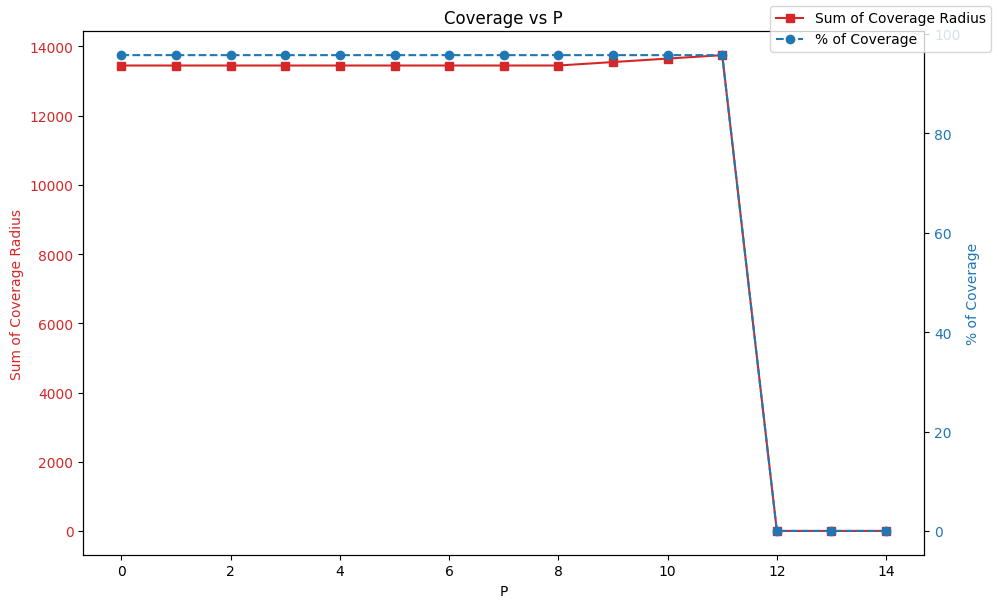

No optimal solution found.
No optimal solution found.
Charger Placement Results:
Sum of coverage radius: 4950.00
Total POIs covered: 229
Proportion of points of interest covered: 70.25%

Charger Placement Results:
Sum of coverage radius: 7500.00
Total POIs covered: 274
Proportion of points of interest covered: 84.05%

Charger Placement Results:
Sum of coverage radius: 10000.00
Total POIs covered: 302
Proportion of points of interest covered: 92.64%

Charger Placement Results:
Sum of coverage radius: 12250.00
Total POIs covered: 309
Proportion of points of interest covered: 94.79%

Charger Placement Results:
Sum of coverage radius: 14800.00
Total POIs covered: 317
Proportion of points of interest covered: 97.24%

Charger Placement Results:
Sum of coverage radius: 17400.00
Total POIs covered: 323
Proportion of points of interest covered: 99.08%

Charger Placement Results:
Sum of coverage radius: 19950.00
Total POIs covered: 325
Proportion of points of interest covered: 99.69%

Charger Pl

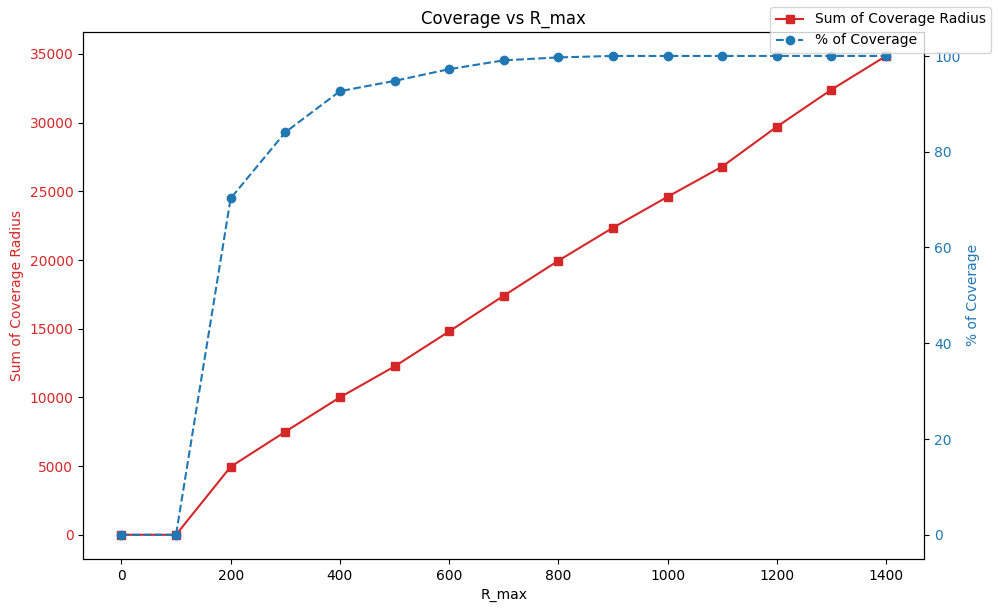

Charger Placement Results:
Sum of coverage radius: 13180.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13400.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13200.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 12880.00
Total POIs covered: 311
Proportion of points of interest covered: 95.40%

Charger Placement Results:
Sum of coverage radius: 12760.00
Total POIs covered: 311
Proportion of points of interest covered: 95.40%

Charger Placement Results:
Sum of coverage radius: 13230.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13475.00
To

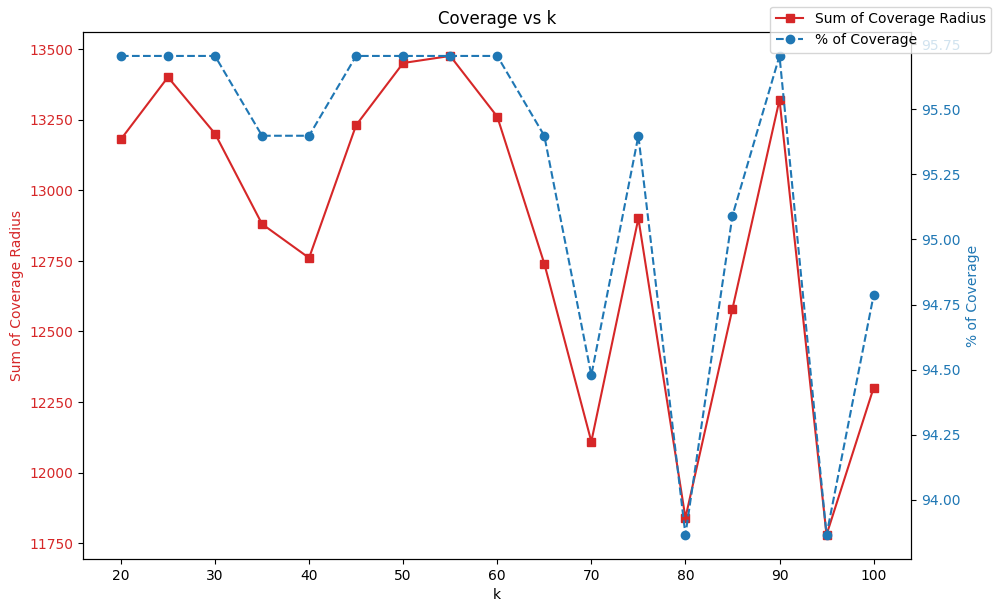

Charger Placement Results:
Sum of coverage radius: 4750.00
Total POIs covered: 203
Proportion of points of interest covered: 62.27%

Charger Placement Results:
Sum of coverage radius: 9500.00
Total POIs covered: 276
Proportion of points of interest covered: 84.66%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Tota

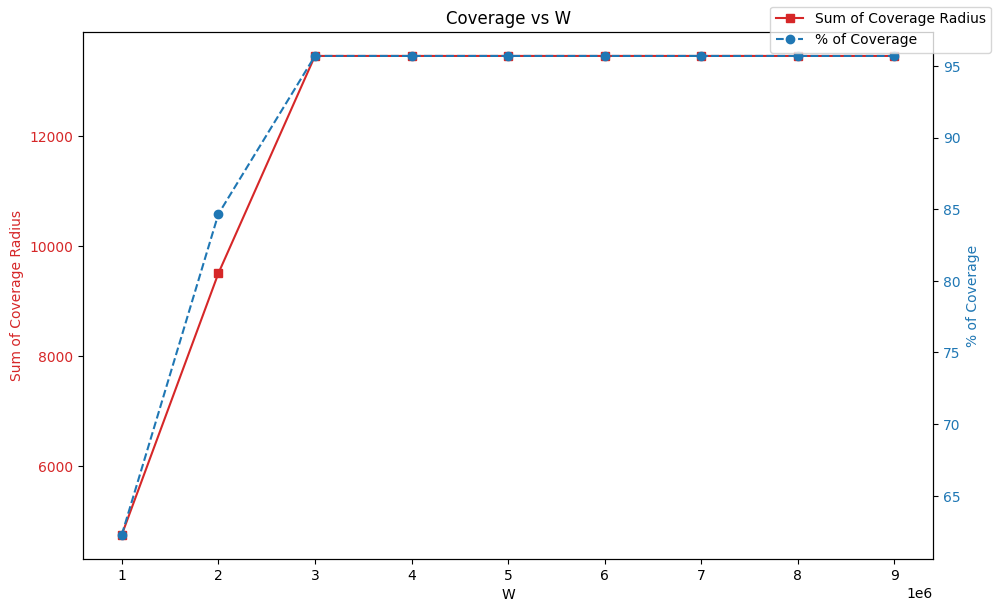

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%

Charger Placement Results:
Sum of coverage radius: 13450.00
Total POIs covered: 312
Proportion of points of interest covered: 95.71%



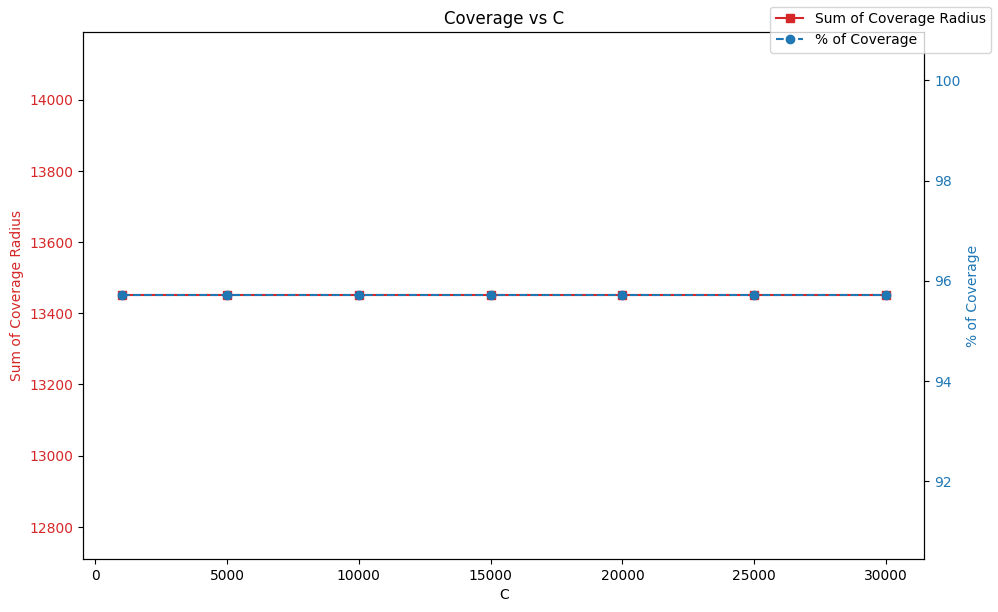

In [145]:
# Analyze coverage vs. minimum number of chargers (P)
min_chargers_values = range(0, 15)  # Minimum number of chargers
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, min_chargers_values, 'P')

# Analyze coverage vs. maximum coverage radius (R_max)
max_radius_values = range(0, 1500, 100)  #Maximum coverage radius
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, max_radius_values, 'R_max')

# Analyze coverage vs. constant for coverage radius calculation (k)
# current model = 50
constant_values = range(20, 101, 5) # Constant values
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, constant_values, 'k')

# Analyze coverage vs budget (W)
# middle value = 12372349
budget_values = range(1000000, 10000000, 1000000)  # Budget values
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, budget_values, "W")

# Analyze coverage vs. variable cost of installing charging stations (C)
# middle value 10,500
cost_values = [1000, 5000, 10000, 15000, 20000, 25000, 30000]  # Example values for variable cost
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, cost_values, "C")

## Alternative LOP - Minimise Cost

In [149]:
# NEW
def solve_ev_optimal_placement_min_cost(B, D, P, k, R_max, C, W, D_ij, print_results=True):
    """
    Solve the EV Optimal Placement Optimization problem.

    Parameters:
    - B (int): Number of car parks.
    - D (int): Number of points of interest.
    - P (int): Minimum number of chargers required at each car park.
    - k (float): Constant for coverage radius calculation.
    - R_max (float): Maximum coverage radius.
    - C (float): Variable cost of installing one charging station.
    - W (float): Total budget.
    - D_ij (dict): Dictionary containing distances between car parks and points of interest.

    Returns:
    - model: Gurobi model object.
    """
    # Create a new Gurobi model
    model = gp.Model("EV_Optimal_Placement")

    # Disable output logging
    model.Params.OutputFlag = 0

    # Decision variables
    Ni = model.addVars(B, lb=P, vtype=GRB.INTEGER, name="Ni")  # Number of chargers
    Ri = model.addVars(B, name="Ri")  # Coverage radius
    Y = model.addVars(B, D, vtype=GRB.BINARY, name="Y")  # Coverage indicator

    # Objective function
    #minimise cost
    obj = gp.quicksum(C * Ni[i] for i in range(B))
    model.setObjective(obj, sense=GRB.MINIMIZE)

    # Constraints
    # Number of chargers constraint
    model.addConstrs((Ni[i] >= P for i in range(B)), name="charger_num_constr")

    # Coverage radius constraint
    model.addConstrs((Ri[i] == k * Ni[i] for i in range(B)), name="radius_constr")

    # Distance constraint
    model.addConstrs((Ri[i] <= R_max for i in range(B)), name="distance_constrs")

    # Coverage constraints
    for i in range(B):
        for j in range(D):
            # D_ij.get(i, {}) returns an empty dictionary if i is not in D_ij
            # .get(j, None) returns None if j is not found in the dictionary returned by D_ij.get(i, {})
            distance = D_ij.get(i, {}).get(j, None)

            if distance is not None:
                # Define binary data x_ij
                #if Dij <= Rmax, Xij = 1, else Xij = 0
                if distance <= R_max:
                    x_ij = 1
                else:
                    x_ij = 0
                # Add constraint for when D_ij is greater than R_max
                model.addConstr(distance * x_ij <= (Ri[i] + 999999 * (1 - Y[i, j])) * x_ij, name=f"coverage_constrs_1_{i}_{j}")
                # Add constraint for when D_ij is less than or equal to R_max
                model.addConstr(distance * x_ij >= (Ri[i] - 999999 * Y[i, j]) * x_ij, name=f"coverage_constrs_2_{i}_{j}")
                # Add constraint to ensure Y_ij = 0 when x_ij = 0
                model.addConstr(Y[i, j] <= x_ij, name=f"coverage_constrs_3_{i}_{j}")

    #for j in range(D):
    #    model.addConstr(gp.quicksum(Y[i, j] for i in range(B)) >= 1, name=f"coverage_constrs_3_{j}")

    # Optimize the model
    model.optimize()

    # Verify problem status
    if model.status == GRB.OPTIMAL:
        # Retrieve and display optimal solutions
        df_charger_placement = pd.DataFrame(
            columns=["Carpark", "Number of chargers", "Coverage radius"]
        )
        # Charger placement at each car park
        print("Charger Placement Results:")
        for i in range(B):
            if print_results == True:
                print(
                    f"Carpark {i}: Number of chargers = {Ni[i].x:.0f}, Coverage radius = {Ri[i].x:.2f} m"
                )
            # make above into a df
            df_charger_placement.loc[i] = [i, Ni[i].x, Ri[i].x]

        # Points of interest coverage
        # print("\nPoints of Interest Coverage:")
        # for j in range(D):
        #    covered = any(Y[i, j].x for i in range(B))
        #    print(f"Point of interest {j}: {'Covered' if covered else 'Not Covered'}")

        # Display objective value
        sum_coverage_radius = sum(Ri[i].x for i in range(B))
        total_pois_covered = sum(
            1
            for j in range(D)
            if any(model.getVarByName(f"Y[{i},{j}]").x for i in range(B))
        )
        proportion_of_pois_covered = (total_pois_covered / D) * 100

        print(f"Sum of coverage radius: {sum_coverage_radius:.2f}")
        print(f"Total POIs covered: {total_pois_covered}")
        print(
            f"Proportion of points of interest covered: {proportion_of_pois_covered:.2f}%\n"
        )

        # Retrieve and display optimal solutions
        obj_value = model.objVal
        return (
            model,
            obj_value,
            sum_coverage_radius,
            proportion_of_pois_covered,
            df_charger_placement, 
        )
    else:
        print("No optimal solution found.")
        return None, None, None, None, None

In [150]:
#run the above function
model_min_cost, obj_value_min_cost, sum_coverage_radius_min_cost, proportion_of_pois_covered_min_cost, df_charger_placement_min_cost = solve_ev_optimal_placement_min_cost(B, D, P, k, R_max, C, W, D_ij)

Charger Placement Results:
Carpark 0: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 1: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 2: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 3: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 4: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 5: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 6: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 7: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 8: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 9: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 10: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 11: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 12: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 13: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 14: Number of chargers = 3, Coverage radius = 150.00 m
Carpark 15: Number of chargers = 3, Co